# Install the code dependencies

In [11]:
!pip install torch torchvision


[notice] A new release of pip is available: 23.0.1 -> 24.1
[notice] To update, run: pip install --upgrade pip


# Download the data set and split it into test and training data sets

In [12]:
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Each training iteration will be passed 4 images
# Larger batch size means we'll need to fit more data in memory, it also means we'll be able to parallelize more and get through all of the training data faster
# Smaller batch sizes result in the overall model parameters being updated more frequently, so there are more opportunities for the model to learn from the previous batches.
batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2) #Shuffle the training data so that the model doesn't learn patterns that just happen to be in the training data set

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


# Print a random sample of the training data

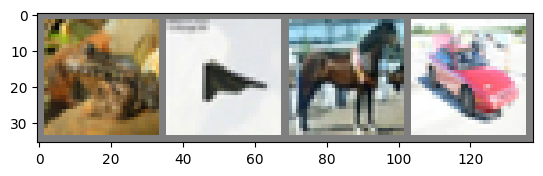

frog  plane horse car  


In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Function to print an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# Pick the first set of images and corresponding labels from the training data set
# Because the trainloader uses the "shuffle=True" argument, we'll get a different batch every time.
# The number of images that will be printed is determined by the "batch_size = 4" line above.
dataiter = iter(trainloader)
images, labels = next(dataiter)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Show the images
imshow(torchvision.utils.make_grid(images))
# Print the corresponding labels for each of the images that we'll print out
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

# Define the neural network

It's difficult to talk through what's going on this code without more time. If you want to dig in here to understand what is going on, I recommend reading more [here](https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html) and also watching [this video series](https://youtube.com/playlist?list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi&si=CfGsmkH9siwYFNHl).

In [14]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

# Show that the model, before training it, isn't very smart

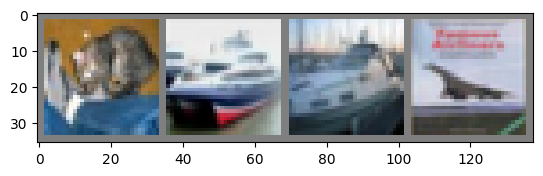

GroundTruth:  cat   ship  ship  plane
Predicted:  ship  ship  ship  ship 


In [15]:
# Select the first batch of images from the test data set
dataiter = iter(testloader)
images, labels = next(dataiter)

# Print the images and the correct classification for teach image
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

# Pass the batch of images to the model
outputs = net(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

# Define the loss function

A loss function answers the question of "how far is the model's outupt from the 'correct' answer?"

In [16]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Train the model

In [17]:
number_of_epochs = 2 # How many times to loop through the training data. The model can get better the more you train it, but there are limits and caveats
for epoch in range(number_of_epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0): # Loop through all of the training data
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.183
[1,  4000] loss: 1.859
[1,  6000] loss: 1.658
[1,  8000] loss: 1.560
[1, 10000] loss: 1.498
[1, 12000] loss: 1.452
[2,  2000] loss: 1.377
[2,  4000] loss: 1.364
[2,  6000] loss: 1.342
[2,  8000] loss: 1.302
[2, 10000] loss: 1.302
[2, 12000] loss: 1.255
Finished Training


# Save the trained model to disk

In [18]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

# Test the trained model

## Start by choosing a batch of data to test with

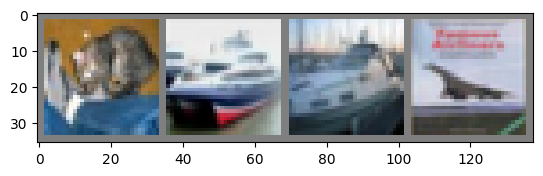

GroundTruth:  cat   ship  ship  plane


In [19]:
# Select the first batch of images from the test data set
dataiter = iter(testloader)
images, labels = next(dataiter)

# Print the images and the correct classification for teach image
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

## Next see what the model _thinks_ each image is

In [20]:
# Load the model from disk
net = Net()
net.load_state_dict(torch.load(PATH))

# Pass the batch of images to the model
outputs = net(images)

# The output of the model is a list of "energies" for each of the image classes. A higher energy corresponds to greater
# confidence that the image matches the corresponding image class.
# In this block, we determine which classification has the highest energy and print the corresponding class.
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  cat   ship  ship  ship 


## Now test every image in the training data set and output the total accuracy

In [21]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 54 %


Credit to [this tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html) for this code.